# Load the necessary libraries

In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [2]:
from functools import partial

import numpy as np

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import equinox as eqx
import optax

from jax_canoak.subjects import get_met_forcings, initialize_parameters, Obs
from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import CanoakBase, CanoakBaseIFT
from jax_canoak.models import get_canle_output, update_canle_output
from jax_canoak.shared_utilities.optim import perform_optimization

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    visualize_tree_diff,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

# Model parameters and settings

In [3]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 2
hypo_amphi = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
meas_ht = 5.0
n_hr_per_day = 48
lai = 5.0
niter = 15

f_forcing = "../data/fluxtower/Alf/AlfBouldinMetInput-yr.csv"

# Load and set the model forcings

In [4]:
met, n_time = get_met_forcings(f_forcing, lai)

# Create the model parameter instance

In [5]:
setup, para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    meas_ht=meas_ht,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)

# Generate or read the dispersion matrix

In [6]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_Alfalfa.csv")

# The default run

In [7]:
jax.clear_caches()
canoak_eqx = CanoakBase(para, setup, dij)
(
    _,
    prof,
    quantum,
    nir,
    ir,
    rnet,
    qin,
    sun_ang,
    leaf_ang,
    lai,
    sun,
    shade,
    soil,
    veg,
    can,
) = canoak_eqx(met)

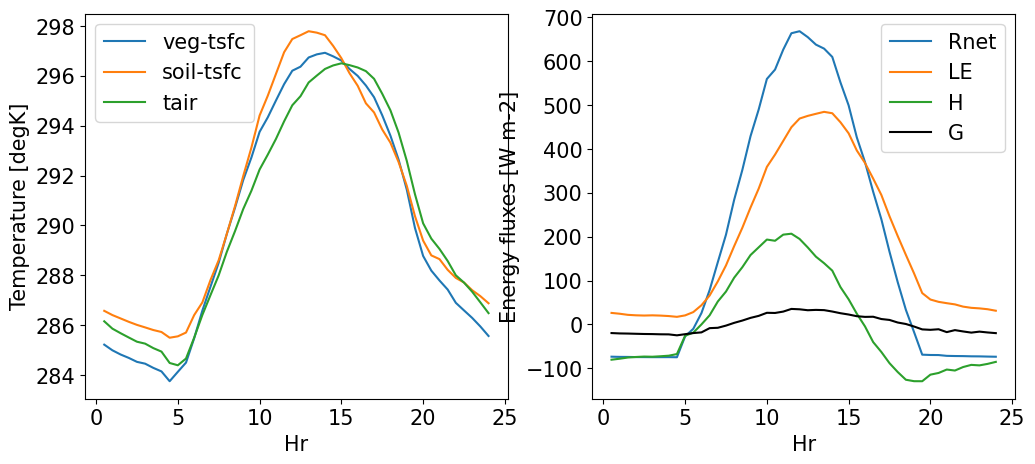

In [8]:
plot_daily(met, soil, veg, para);

# The IFT version

In [9]:
jax.clear_caches()
canoak_eqx_ift = CanoakBaseIFT(para, setup, dij)
met, prof, ir, qin, sun, shade, soil, veg, can = canoak_eqx_ift(met)
# (
#     _,
#     prof,
#     quantum,
#     nir,
#     ir,
#     rnet,
#     qin,
#     sun_ang,
#     leaf_ang,
#     lai,
#     sun,
#     shade,
#     soil,
#     veg,
#     can,
# ) = canoak_eqx_ift(met)

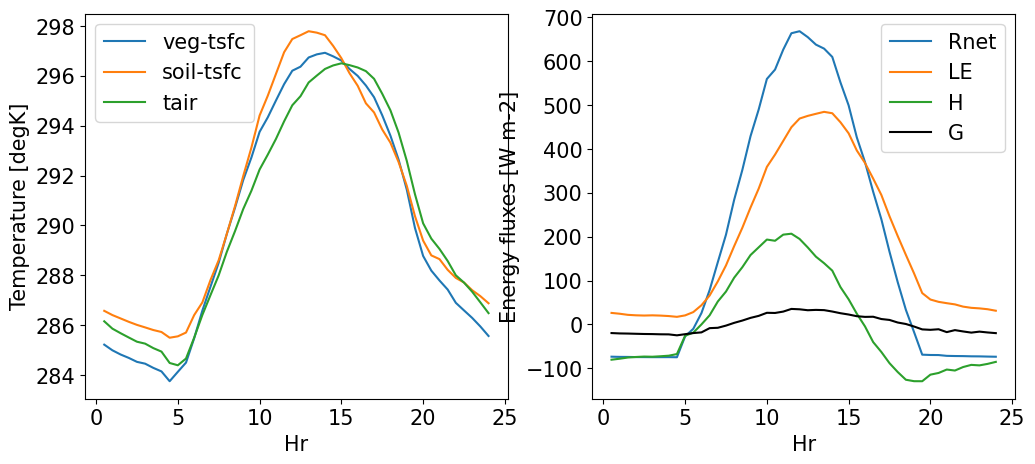

In [10]:
plot_daily(met, soil, veg, para);

# Gradient calculation

## The default version

In [27]:
@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    (
        _,
        prof,
        quantum,
        nir,
        ir,
        rnet,
        qin,
        sun_ang,
        leaf_ang,
        lai,
        sun,
        shade,
        soil,
        veg,
        can,
    ) = canoak_eqx(met)
    return can.LE.sum()

In [35]:
jax.clear_caches()
gradients = df_canoak_le(para, met, canoak_eqx)

In [37]:
%timeit df_canoak_le(para, met, canoak_eqx)

8.08 s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
gradients.bprime

Array(985036.79775847, dtype=float64, weak_type=True)

## The IFT version

In [13]:
@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le_ift(para, met, canoak_eqx_ift):
    canoak_eqx_ift = eqx.tree_at(lambda t: t.para, canoak_eqx_ift, para)
    LE = canoak_eqx_ift(met, update_canle_output, get_canle_output)
    return LE.sum()

In [14]:
jax.clear_caches()
gradients_ift = df_canoak_le_ift(para, met, canoak_eqx_ift)

In [38]:
%timeit df_canoak_le_ift(para, met, canoak_eqx_ift)

716 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
gradients_ift.bprime

Array(1057728.21108563, dtype=float64, weak_type=True)

# Vector gradient calcuation

## The default run

In [18]:
@eqx.filter_jit
@partial(jax.jacrev, argnums=0)
def df_canoak_le2(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    (
        _,
        prof,
        quantum,
        nir,
        ir,
        rnet,
        qin,
        sun_ang,
        leaf_ang,
        lai,
        sun,
        shade,
        soil,
        veg,
        can,
    ) = canoak_eqx(met)
    return can.LE

In [19]:
jax.clear_caches()
gradients2 = df_canoak_le2(para, met, canoak_eqx)

[(0.0, 5000.0)]

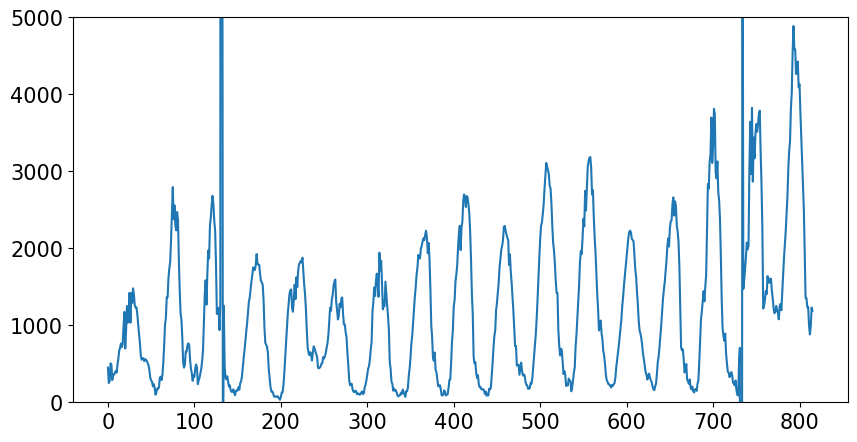

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(gradients2.bprime)
ax.set(ylim=[0, 5000])

## The IFT run

In [15]:
@eqx.filter_jit
@partial(jax.jacrev, argnums=0)
def df_canoak_le_ift2(para, met, canoak_eqx_ift):
    canoak_eqx_ift = eqx.tree_at(lambda t: t.para, canoak_eqx_ift, para)
    LE = canoak_eqx_ift(met, update_canle_output, get_canle_output)
    return LE

In [16]:
jax.clear_caches()
gradients_ift2 = df_canoak_le_ift2(para, met, canoak_eqx_ift)

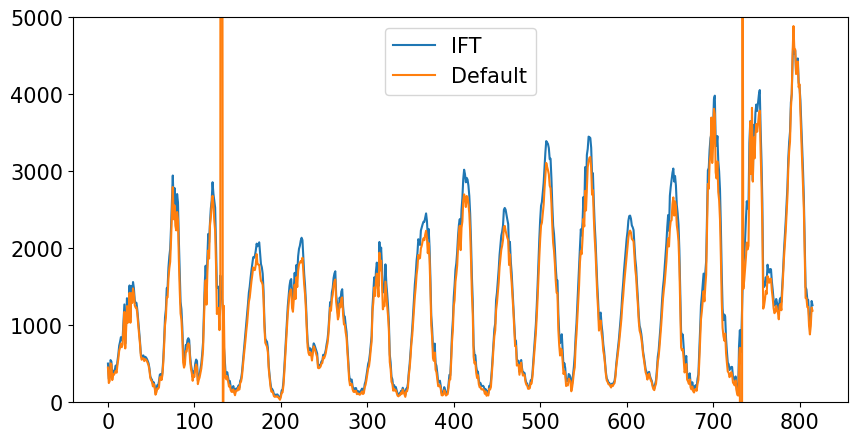

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(gradients_ift2.bprime, label="IFT")
ax.plot(gradients2.bprime, label="Default")
ax.set(ylim=[0, 5000])
ax.legend()

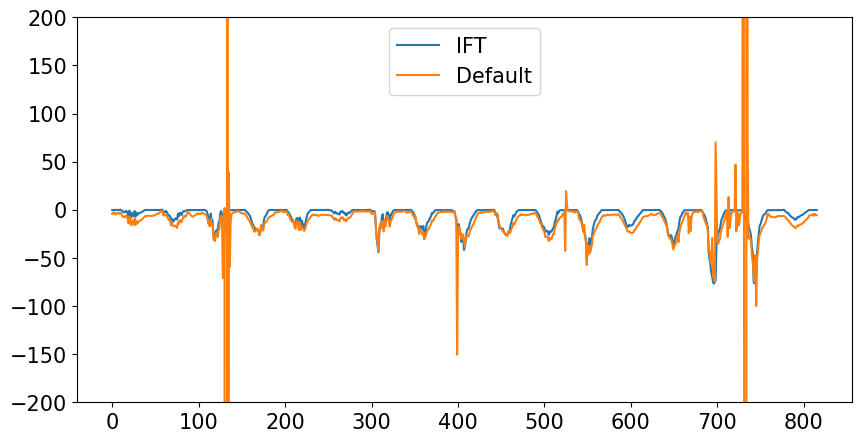

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(gradients_ift2.ep, label="IFT")
ax.plot(gradients2.ep, label="Default")
ax.set(ylim=[-200, 200])
ax.legend()

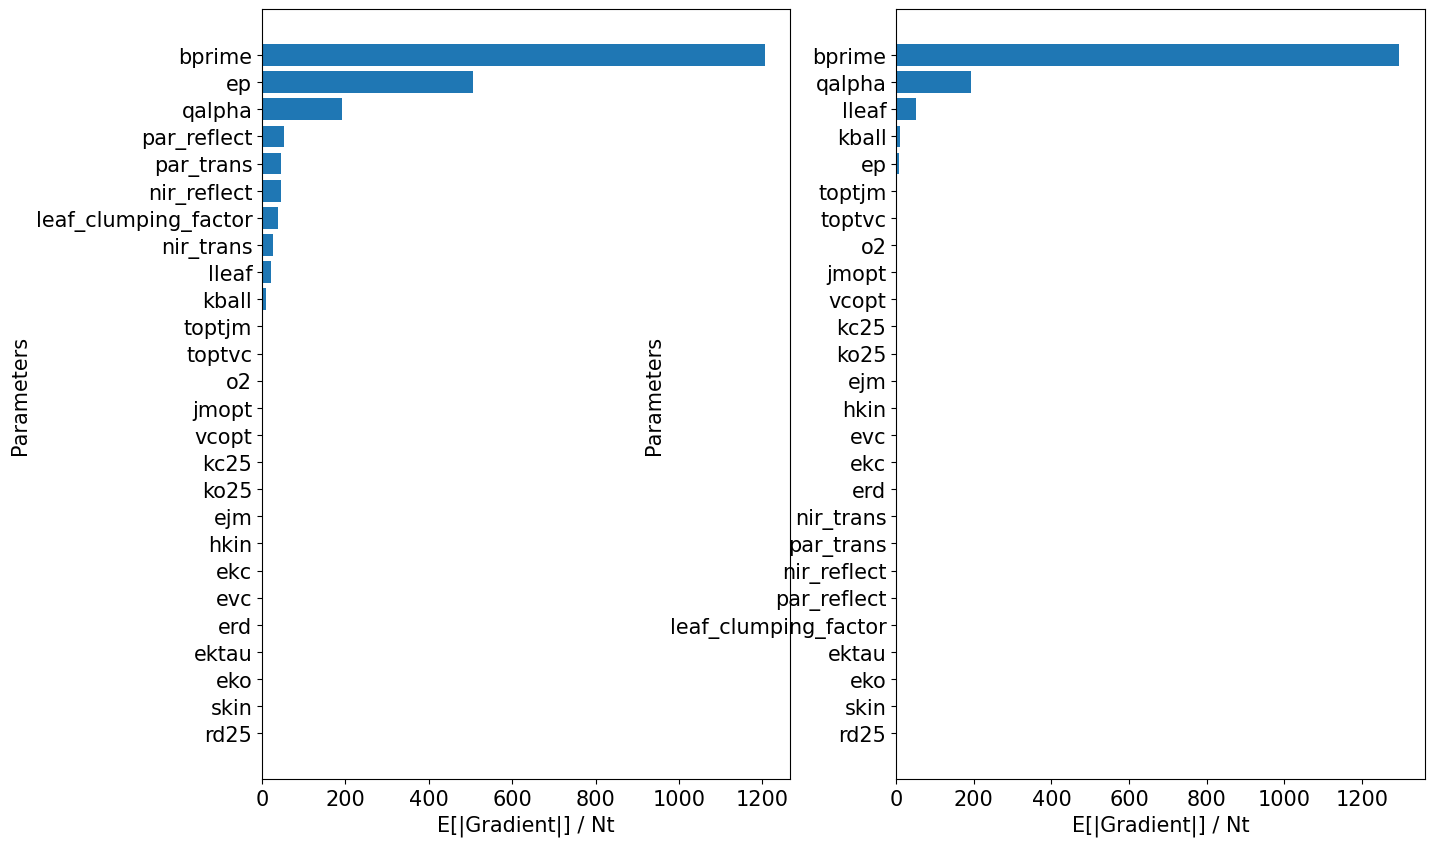

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
ax = axes[0]
plot_para_sensitivity_ranking(gradients2, category="photosyn", ax=ax)
ax = axes[1]
plot_para_sensitivity_ranking(gradients_ift2, category="photosyn", ax=ax)